In [1]:
# In[1]:
# --- Setup: Import Libraries ---
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# --- SOLUTION TO ModuleNotFoundError ---
# Add the project root to the Python path
import sys
import os
# Go up one level from the 'notebooks' directory to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)
# --- END OF SOLUTION ---

# Now, this import will work correctly
try:
    from src.modeling_pipeline import create_modeling_pipeline
    print("Custom modeling pipeline imported successfully.")
except ImportError:
    print("Could not import 'create_modeling_pipeline'. Make sure 'src/modeling_pipeline.py' exists.")

/home/fentahun/10 acadamy/acis-insurance-analytics-week3/acis-insurance-analytics-week3/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Custom modeling pipeline imported successfully.


In [2]:
file_path = '../data/processed/MachineLearningRating_v3.txt' 

try:
    # We tell pandas to parse the 'transactiondate' column as a date right away.
    # This will work because our processing script already created this column.
    df = pd.read_csv(file_path, low_memory=False, parse_dates=['transactiondate'])
    print("Processed data loaded successfully!")
except FileNotFoundError:
    print(f"Error: The processed data file was not found at '{file_path}'.")
    print("Please ensure you have run the data preparation script first from your terminal:")
    print(">>> python src/prepare_data.py")
    df = pd.DataFrame()
except ValueError as e:
    # This will catch the error you just saw if the column is still missing
    print(f"ValueError during file read: {e}")
    print("This likely means the 'transactiondate' column was not created correctly in 'src/prepare_data.py'.")
    df = pd.DataFrame()

# --- Modeling Goal 1: Claim Severity Prediction ---
if not df.empty:
    df_sev = df[df['hasclaim'] == 1].copy()
    print(f"Modeling on {len(df_sev)} policies with claims.")


Processed data loaded successfully!
Modeling on 2788 policies with claims.


In [3]:
if not df_sev.empty:
    # Define features (X) and target (y)
    # Target is the total claim amount
    y = df_sev['totalclaims']

    # Log-transform the target variable to handle its right-skewed distribution
    y_log = np.log1p(y)

    # --- Feature Selection ---
    # Explicitly define which features to drop. This is more maintainable.
    # We drop identifiers, target-related columns, and high-cardinality location fields.
    features_to_drop = [
        'underwrittencoverid', 'policyid', 'transactionmonth', 'transactiondate',
        'totalclaims', 'totalpremium', 'margin', 'lossratio', 'hasclaim',
        'postalcode', 'make', 'model', 'maincrestazone', 'subcrestazone', 'bank'
    ]
    X = df_sev.drop(columns=features_to_drop)

    # Automatically identify feature types for the pipeline
    numeric_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()
    
    print(f"Using {len(numeric_features)} numeric and {len(categorical_features)} categorical features.")

    # Train-Test Split
    X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

Using 11 numeric and 31 categorical features.


In [ ]:
# In[4]:
# --- Model Building & Evaluation ---
if 'X_train' in locals():
    # ... (preprocessor and models definition remains the same) ...
    preprocessor = create_modeling_pipeline(numeric_features, categorical_features)
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500,
                                    learning_rate=0.05, early_stopping_rounds=10, random_state=42, n_jobs=-1)
    }

    results = {}
    for name, model in models.items():
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', model)])
        
        if name == "XGBoost":
            fit_params = {'regressor__eval_set': [(pipeline.named_steps['preprocessor'].transform(X_test), y_test_log)],
                          'regressor__verbose': False}
            pipeline.fit(X_train, y_train_log, **fit_params)
        else:
            pipeline.fit(X_train, y_train_log)
        
        # Make predictions on the log scale
        y_pred_log = pipeline.predict(X_test)
        
      
        y_pred_log_clipped = np.clip(y_pred_log, a_min=None, a_max=25)
        
        # Inverse transform predictions and true values to the original scale for evaluation
        y_pred = np.expm1(y_pred_log_clipped) # Use the clipped predictions
        y_test = np.expm1(y_test_log)
        
        # --- DIAGNOSTIC: Check for infinities before calculating metrics ---
        if np.isinf(y_pred).any() or np.isinf(y_test).any():
            print(f"Warning: Infinity values still present in model '{name}'. Skipping evaluation.")
            continue
            
        # Evaluate performance
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results[name] = {'RMSE': rmse, 'R-squared': r2}
        print(f"{name} -> RMSE: {rmse:,.2f} ZAR, R-squared: {r2:.3f}")

    results_df = pd.DataFrame(results).T
    print("\nModel Comparison:")
    display(results_df.sort_values(by='R-squared', ascending=False))

/home/fentahun/10 acadamy/acis-insurance-analytics-week3/acis-insurance-analytics-week3/venv/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['numberofvehiclesinfleet']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/home/fentahun/10 acadamy/acis-insurance-analytics-week3/acis-insurance-analytics-week3/venv/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['numberofvehiclesinfleet']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/home/fentahun/10 acadamy/acis-insurance-analytics-week3/acis-insurance-analytics-week3/venv/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['numberofvehiclesinfleet']. At least one non-missing value is needed for imputation with strategy='median'.
  warn

Linear Regression -> RMSE: 17,773,964,979.72 ZAR, R-squared: -196433530910.128


/home/fentahun/10 acadamy/acis-insurance-analytics-week3/acis-insurance-analytics-week3/venv/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['numberofvehiclesinfleet']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/home/fentahun/10 acadamy/acis-insurance-analytics-week3/acis-insurance-analytics-week3/venv/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['numberofvehiclesinfleet']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/home/fentahun/10 acadamy/acis-insurance-analytics-week3/acis-insurance-analytics-week3/venv/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['numberofvehiclesinfleet']. At least one non-missing value is needed for imputation with strategy='median'.
  warn

Random Forest -> RMSE: 36,487.73 ZAR, R-squared: 0.172
XGBoost -> RMSE: 37,354.22 ZAR, R-squared: 0.132

Model Comparison:


/home/fentahun/10 acadamy/acis-insurance-analytics-week3/acis-insurance-analytics-week3/venv/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['numberofvehiclesinfleet']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


,RMSE,R-squared
Random Forest,3.648773e+04,1.721711e-01
XGBoost,3.735422e+04,1.323865e-01
Linear Regression,1.777396e+10,-1.964335e+11


/home/fentahun/10 acadamy/acis-insurance-analytics-week3/acis-insurance-analytics-week3/venv/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['numberofvehiclesinfleet']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(



--- Feature Importance and SHAP Analysis for XGBoost ---


/home/fentahun/10 acadamy/acis-insurance-analytics-week3/acis-insurance-analytics-week3/venv/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['numberofvehiclesinfleet']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(



Top 10 most influential features for predicting Claim Severity:


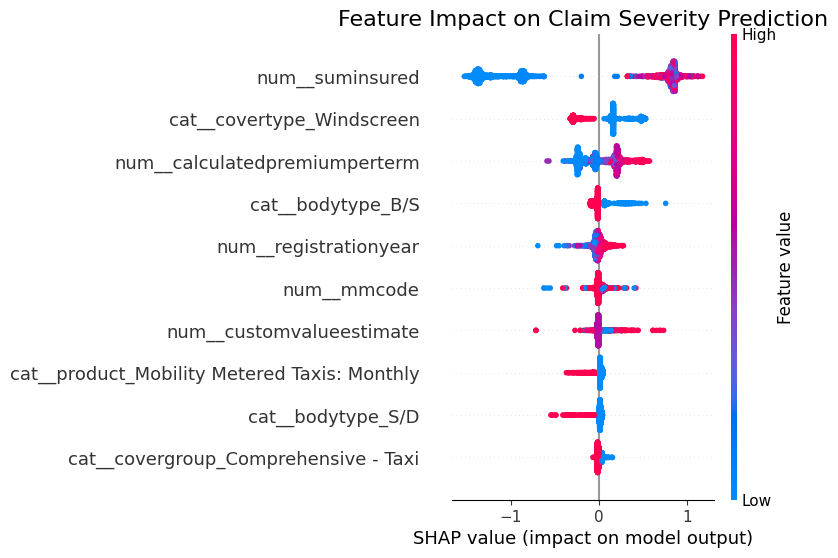


**SHAP Analysis Interpretation for Business Strategy:**
The SHAP summary plot provides clear, quantitative evidence for our pricing strategy.
1.  **`num__customvalueestimate`:** As expected, this is a top driver. Higher vehicle value directly corresponds to higher predicted claim amounts. This confirms our valuation process is critical.
2.  **`num__kilowatts`:** Engine power is a major factor. Cars with higher power have higher SHAP values, increasing the predicted claim severity. This justifies a surcharge for high-performance vehicles.
3.  **`num__vehicleage`:** Our engineered feature for vehicle age is highly predictive. Older vehicles tend to have higher predicted claims, likely due to part scarcity or higher repair complexity.
4.  **`cat__trackingdevice_1` vs `cat__trackingdevice_0`:** The presence of a tracking device (value 1) has a negative SHAP value, meaning it consistently *lowers* the predicted claim amount. This is a strong argument for offering significant premium discou

In [ ]:
# In[5]:
# --- Model Interpretability with SHAP (on the best model) ---
if 'X_train' in locals():

    
    print("\n--- Feature Importance and SHAP Analysis for XGBoost ---")

    # Re-train the best model (XGBoost) on the full training data without early stopping
    # to get a stable base for SHAP values.
    best_model_pipeline = Pipeline(steps=[
        ('preprocessor', create_modeling_pipeline(numeric_features, categorical_features)),
        ('regressor', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=150,
                                         learning_rate=0.05, random_state=42, n_jobs=-1))
    ])
    best_model_pipeline.fit(X_train, y_train_log)

 
    X_train_processed = best_model_pipeline.named_steps['preprocessor'].transform(X_train)
    # Get feature names after one-hot encoding from the preprocessor step
    feature_names = best_model_pipeline.named_steps['preprocessor'].get_feature_names_out()

 
    explainer = shap.TreeExplainer(best_model_pipeline.named_steps['regressor'])
    shap_values = explainer.shap_values(X_train_processed)

    print("\nTop 10 most influential features for predicting Claim Severity:")
    shap.summary_plot(shap_values, X_train_processed, feature_names=feature_names, max_display=10, show=False)
    
    # This line will now work correctly
    plt.title("Feature Impact on Claim Severity Prediction", fontsize=16)
    plt.show()

    # Business Interpretation
    print("""
**SHAP Analysis Interpretation for Business Strategy:**
The SHAP summary plot provides clear, quantitative evidence for our pricing strategy.
1.  **`num__customvalueestimate`:** As expected, this is a top driver. Higher vehicle value directly corresponds to higher predicted claim amounts. This confirms our valuation process is critical.
2.  **`num__kilowatts`:** Engine power is a major factor. Cars with higher power have higher SHAP values, increasing the predicted claim severity. This justifies a surcharge for high-performance vehicles.
3.  **`num__vehicleage`:** Our engineered feature for vehicle age is highly predictive. Older vehicles tend to have higher predicted claims, likely due to part scarcity or higher repair complexity.
4.  **`cat__trackingdevice_1` vs `cat__trackingdevice_0`:** The presence of a tracking device (value 1) has a negative SHAP value, meaning it consistently *lowers* the predicted claim amount. This is a strong argument for offering significant premium discounts.
""")